In [109]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries
import lal,h5py
import Functions as fun
from scipy.interpolate import interp1d
from scipy.signal import find_peaks,savgol_filter

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [3]:
!echo $PYTHONPATH

/software/tools/pegasus/5.0/lib/python3.7/dist-packages/:/work/yifan.wang/eccsearch/waveform/ihes-teobresum/Python:/work/yifan.wang/eccsearch/waveform/PyCBC-teobresums:/work/yifan.wang/1-ecc-waveform-PE/IMRPhenomDecc:/work/yifan.wang/lscsoft/src/TaylorF2e:


# Validating the validation paper

In [63]:
def time_to_t_NR(t,mtotal):
    return t/mtotal/lal.MTSUN_SI

lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)

(0.6307831305050401+0j)

In [79]:
import sxs

class sxswave(object):
    '''
    Class to read and plot SXS waveforms.
    Only return h22 and sliced waveform starting from reference time
    '''
    def __init__(self,sxsid,ext_order=4):
        #load the data and metadata.json
        self.hlm = sxs.load("SXS:BBH:"+str(sxsid)+"/Lev/rhOverM", extrapolation_order=ext_order)
        self.metadata = sxs.load("SXS:BBH:"+str(sxsid)+"/Lev/metadata.json")

        # time slide the 0 time point to the maximum norm position
        # self.max_norm_time = self.hlm.max_norm_time()
        # AttributeError: can't set attribute
        
        # chop off the junk radiation
        self.reference_index = self.hlm.index_closest_to(self.metadata.reference_time)
        self.hlm_sliced = self.hlm[self.reference_index:]
        
        # Only consider the h22 mode in this work, higher modes left to future
        self.h22 = self.hlm_sliced[:, self.hlm.index(2, 2)]
        
    def hphc(self,theta,phi):
        '''
        Evaluate h+ - ihx = hlm -2Ylm(theta,phi)
        '''
        return self.hlm_sliced.evaluate(theta, phi)
    
    def h22_pycbcts(self,dt=None):
        #interpolation
        sxs_h22_interp = interp1d(self.h22.t,self.h22.data,kind='cubic')
        #uniform time array
        t_start = self.h22.t[0]
        t_end = self.h22.t[-1]
        if dt==None:
            dt = np.min(np.diff(self.h22.t))
        else:
            pass
        t_uniform = np.arange(t_start, t_end, dt)
        sxs_h22 = sxs_h22_interp(t_uniform)
        #h = self.h22.interpolate(t_uniform)
        #return TimeSeries(h.data, delta_t=dt,epoch = -dt*np.argmax(np.abs(h.data)))
        return TimeSeries(sxs_h22,delta_t=dt,epoch=-dt*np.argmax(np.abs(sxs_h22)))
    
    def hp_pycbcts_phyunit(self,**kwargs):
        
        mtotal = kwargs['mass1'] + kwargs['mass2']
        distance = kwargs['distance']
        amp_factor = distance*1e6*lal.PC_SI / mtotal /lal.MRSUN_SI
        time_factor = 1/ mtotal /lal.MTSUN_SI

        t_start = self.h22.t[0]
        t_end = self.h22.t[-1]
        dt = np.min(np.diff(self.h22.t))
        if dt / time_factor < kwargs['delta_t']:
            dt  = time_factor * kwargs['delta_t']
        else:
            raise ValueError("dt (in physics unit) larger than the delta_t required")
        t_uniform = np.arange(t_start, t_end, dt)
        h = self.h22.interpolate(t_uniform)
        return TimeSeries(np.real(h.data * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2))/ amp_factor,\
                          delta_t=dt / time_factor,\
                          epoch = -dt*np.argmax(np.abs(np.real(h.data * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)))) / time_factor)

In [88]:
nr= sxswave(1358)
dt=time_to_t_NR(1/1024.,100)
wf = nr.h22_pycbcts()

Found the following files to load from the SXS catalog:
    SXS:BBH:1358v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1358v5/Lev3/metadata.json


Text(0, 0.5, 'Phase')

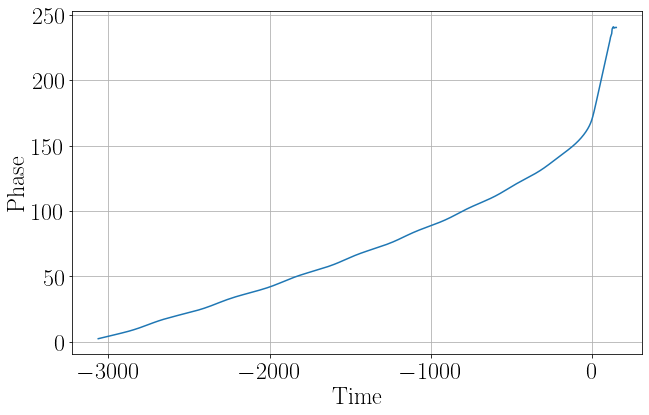

In [89]:
plt.plot(wf.sample_times,-np.unwrap(np.angle(wf)))
plt.xlabel('Time')
plt.ylabel('Phase')

Text(0, 0.5, 'Frequency')

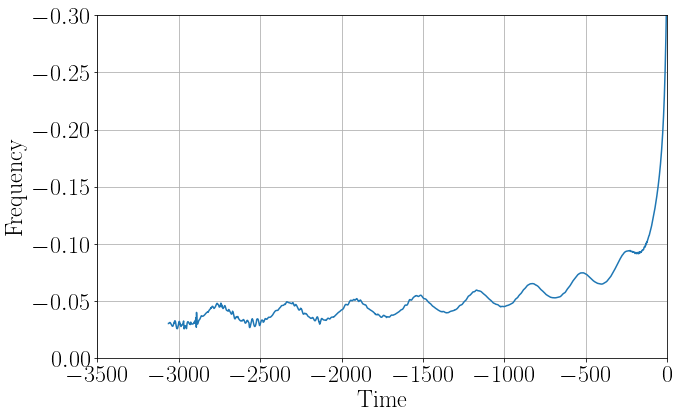

In [92]:
plt.plot(wf.sample_times,np.gradient(np.unwrap(np.angle(wf)),wf.sample_times))
plt.xlim(-3500,0)
plt.ylim(0,-0.3)
plt.xlabel('Time')
plt.ylabel('Frequency')

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

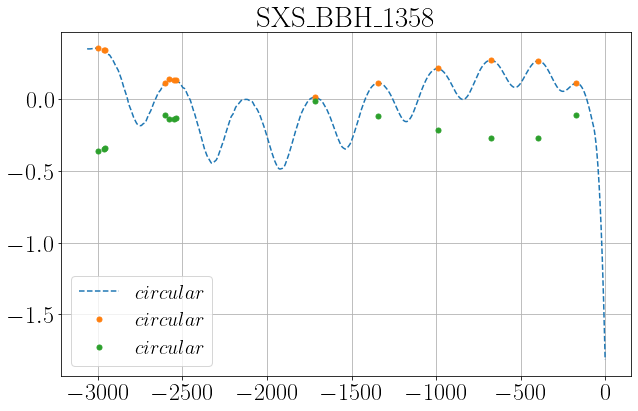

In [126]:
# Find eccentricity from orbital frequency
l = wf.sample_times<0
time = wf.sample_times[l]
freq = -np.gradient(np.unwrap(np.angle(wf[l])),time)

quadfit_par=np.polyfit(time, freq, 2)
freq_quadfit = np.poly1d(quadfit_par)

freq_ecc_estimate = 1 - freq/freq_quadfit(time)
#freq_ecc_estimate = fun.moving_average(freq_ecc_estimate, 20)
# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
freq_ecc_estimate = savgol_filter(freq_ecc_estimate, 201, 3)

peaks_pos=find_peaks(freq_ecc_estimate, height=0)
peaks_neg=find_peaks(freq_ecc_estimate, height=-0)

plt.plot(time, freq_ecc_estimate, '--', label=r'$circular$')
plt.plot(time[peaks_pos[0]], peaks_pos[1]['peak_heights'], 'o', ms=5,label=r'$circular$')
plt.plot(time[peaks_neg[0]],-peaks_neg[1]['peak_heights'], 'o', ms=5,label=r'$circular$')
plt.title('SXS_BBH_1358')
plt.legend()

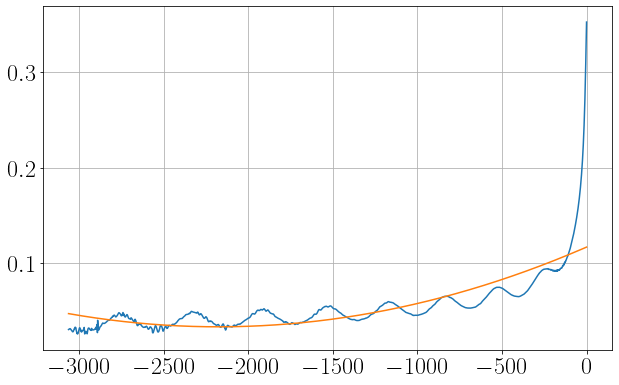

In [100]:
plt.plot(time,freq)
plt.plot(time,freq_quadfit(time))

In [101]:
freq_ecc_estimate = 1 - freq/freq_quadfit(time)
#freq_ecc_estimate = fun.moving_average(freq_ecc_estimate, 20)

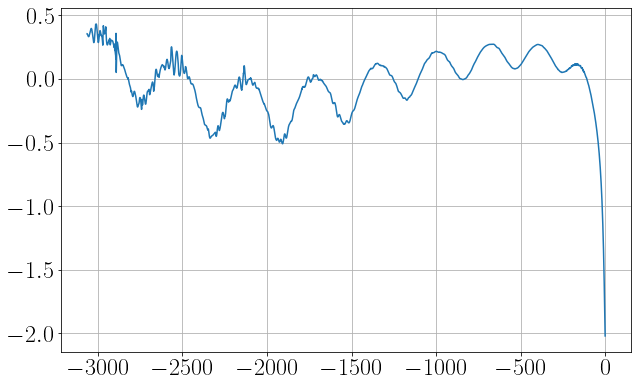

In [102]:
plt.plot(time,freq_ecc_estimate)

In [123]:
freq_ecc_estimate = 1 - freq/freq_quadfit(time)
freq_ecc_estimate = savgol_filter(freq_ecc_estimate, 151, 3)

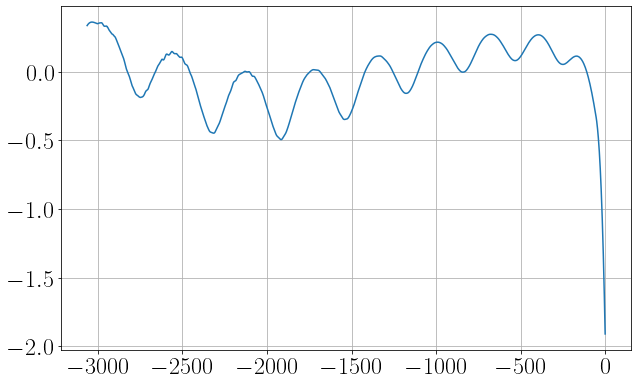

In [124]:
plt.plot(time,freq_ecc_estimate)

# Comparison

In [24]:
f = h5py.File("/work/francisco.jimenez/SXS/data/SXS_BBH_1358/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5","r")

In [50]:
a = f['Extrapolated_N4.dir']['Y_l2_m2.dat']
b = f['Extrapolated_N4.dir']['Y_l2_m-2.dat']

In [51]:
b[:,2]

array([2.06683964e-03, 2.06651891e-03, 2.06369448e-03, ...,
       1.55465567e-05, 1.55342023e-05, 1.55185097e-05])

In [33]:
a[:,2]

array([-2.06687140e-03, -2.06655417e-03, -2.06372746e-03, ...,
       -1.55465535e-05, -1.55341978e-05, -1.55185038e-05])

In [37]:
sxsid = 1358
hlm = sxs.load("SXS:BBH:"+str(sxsid)+"/Lev/rhOverM", extrapolation_order=4)

Found the following files to load from the SXS catalog:
    SXS:BBH:1358v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [43]:
h22 = hlm[:,hlm.index(2,2)]

In [44]:
h22

WaveformModes([-3.00724272e-04-2.06687140e-03j, -3.10964564e-04-2.06655417e-03j,
       -3.22942525e-04-2.06372746e-03j, ...,
        3.57359560e-06-1.55465535e-05j,  3.51621779e-06-1.55341978e-05j,
        3.46046266e-06-1.55185038e-05j], time=array([-108.07492085, -107.39510631, -106.71529176, ..., 3527.12174304,
       3527.22174129, 3527.32173954]), time_axis=0)

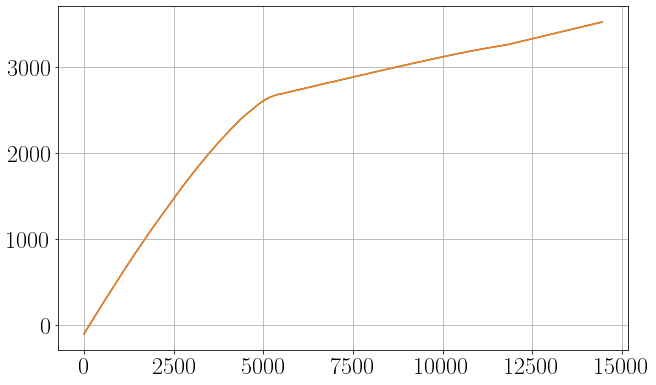

In [53]:
plt.plot(a[:,0])
plt.plot(b[:,0])

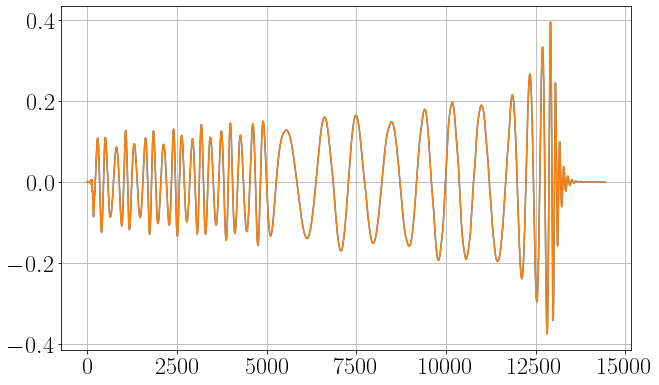

In [57]:
plt.plot(a[:,1])
plt.plot(b[:,1])

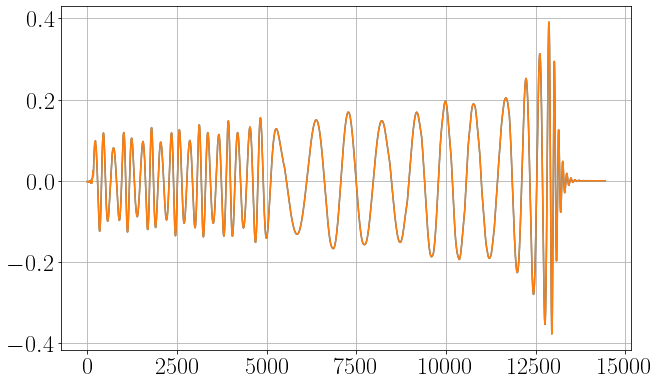

In [58]:
plt.plot(a[:,2])
plt.plot(-b[:,2])

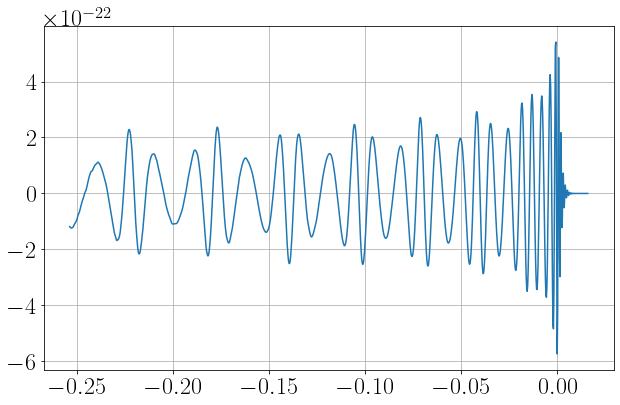

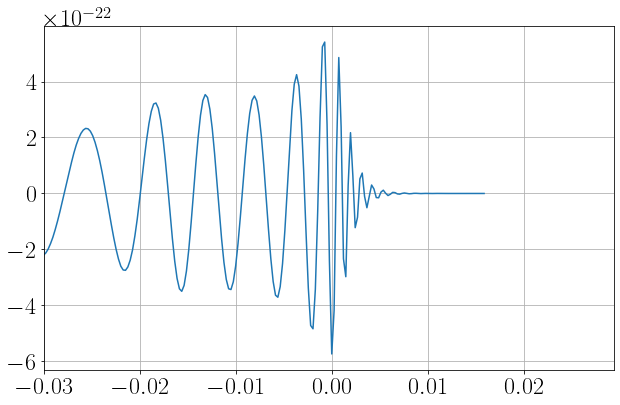

In [6]:
plt.plot(nr_hp_phyunit.sample_times,(nr_hp_phyunit.data.data))
plt.show()

plt.plot(nr_hp_phyunit.sample_times,np.real(nr_hp_phyunit.data.data))
plt.xlim(-0.03,)
plt.show()

# NR waveform parameters, especially initial frequency,spin

In [7]:
mtotal = kwargs['mass1']+kwargs['mass2']
time_factor = 1/ mtotal /lal.MTSUN_SI
print('initial frequency is:', nr_wf.metadata['initial_orbital_frequency'] * time_factor)

initial frequency is: 113.88419110645222


In [8]:
print('spin1 is :', nr_wf.metadata['reference_dimensionless_spin1'])
print('spin2 is :', nr_wf.metadata['reference_dimensionless_spin2'])

spin1 is : [-1.83985610931e-08, -3.3802957018e-09, 1.21703736618e-05]
spin2 is : [2.0295334932e-08, 2.8149471693e-09, 1.20317126489e-05]


# Generating TEOBResumS

# Generating h22 of SEOBNRE

In [60]:
flowpsd = 20
flownr = nr_wf.metadata['initial_orbital_frequency'] * time_factor

for ecc in np.arange(0,0.59,0.01):
    nr_hp_phyunit = nr_wf.hp_pycbcts_phyunit(**kwargs)
    seobhp,_ = get_td_waveform(approximant='SEOBNRE',**kwargs,eccentricity=ecc)
    tlen = max(len(seobhp),len(nr_hp_phyunit))
    seobhp.resize(tlen)
    nr_hp_phyunit.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / seobhp.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, flowpsd)

    m, i = match(seobhp, nr_hp_phyunit, psd=psd, low_frequency_cutoff=flownr)
    
    print('e is', ecc)
    print('The match between SEOBNRE and NR is: {:.4f}'.format(m))

e is 0.0
The match between SEOBNRE and NR is: 0.8543
e is 0.01
The match between SEOBNRE and NR is: 0.8515
e is 0.02
The match between SEOBNRE and NR is: 0.8520
e is 0.03
The match between SEOBNRE and NR is: 0.8472
e is 0.04
The match between SEOBNRE and NR is: 0.8469
e is 0.05
The match between SEOBNRE and NR is: 0.8413
e is 0.06
The match between SEOBNRE and NR is: 0.8551
e is 0.07
The match between SEOBNRE and NR is: 0.8561
e is 0.08
The match between SEOBNRE and NR is: 0.8408
e is 0.09
The match between SEOBNRE and NR is: 0.8538
e is 0.1
The match between SEOBNRE and NR is: 0.8402
e is 0.11
The match between SEOBNRE and NR is: 0.8602
e is 0.12
The match between SEOBNRE and NR is: 0.8385
e is 0.13
The match between SEOBNRE and NR is: 0.8662
e is 0.14
The match between SEOBNRE and NR is: 0.8468
e is 0.15
The match between SEOBNRE and NR is: 0.8406
e is 0.16
The match between SEOBNRE and NR is: 0.8596
e is 0.17
The match between SEOBNRE and NR is: 0.8647
e is 0.18
The match between SE

In [62]:
for ecc in np.arange(0.56,0.58,0.001):
    nr_hp_phyunit = nr_wf.hp_pycbcts_phyunit(**kwargs)
    seobhp,_ = get_td_waveform(approximant='SEOBNRE',**kwargs,eccentricity=ecc)
    tlen = max(len(seobhp),len(nr_hp_phyunit))
    seobhp.resize(tlen)
    nr_hp_phyunit.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / seobhp.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, flowpsd)

    m, i = match(seobhp, nr_hp_phyunit, psd=psd, low_frequency_cutoff=flownr)
    
    print('e is', ecc)
    print('The match between SEOBNRE and NR is: {:.4f}'.format(m))

e is 0.56
The match between SEOBNRE and NR is: 0.8090
e is 0.561
The match between SEOBNRE and NR is: 0.9299
e is 0.562
The match between SEOBNRE and NR is: 0.9348
e is 0.5630000000000001
The match between SEOBNRE and NR is: 0.8572
e is 0.5640000000000001
The match between SEOBNRE and NR is: 0.7660
e is 0.5650000000000001
The match between SEOBNRE and NR is: 0.7065
e is 0.5660000000000001
The match between SEOBNRE and NR is: 0.6570
e is 0.5670000000000001
The match between SEOBNRE and NR is: 0.6667
e is 0.5680000000000001
The match between SEOBNRE and NR is: 0.7942
e is 0.5690000000000001
The match between SEOBNRE and NR is: 0.9258
e is 0.5700000000000001
The match between SEOBNRE and NR is: 0.9411
e is 0.5710000000000001
The match between SEOBNRE and NR is: 0.8681
e is 0.5720000000000001
The match between SEOBNRE and NR is: 0.7758
e is 0.5730000000000001
The match between SEOBNRE and NR is: 0.6941
e is 0.5740000000000001
The match between SEOBNRE and NR is: 0.6624
e is 0.5750000000000

In [63]:
for ecc in np.arange(0.577,0.579,0.0001):
    nr_hp_phyunit = nr_wf.hp_pycbcts_phyunit(**kwargs)
    seobhp,_ = get_td_waveform(approximant='SEOBNRE',**kwargs,eccentricity=ecc)
    tlen = max(len(seobhp),len(nr_hp_phyunit))
    seobhp.resize(tlen)
    nr_hp_phyunit.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / seobhp.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, flowpsd)

    m, i = match(seobhp, nr_hp_phyunit, psd=psd, low_frequency_cutoff=flownr)
    
    print('e is', ecc)
    print('The match between SEOBNRE and NR is: {:.4f}'.format(m))

e is 0.577
The match between SEOBNRE and NR is: 0.8968
e is 0.5771
The match between SEOBNRE and NR is: 0.9127
e is 0.5771999999999999
The match between SEOBNRE and NR is: 0.9240
e is 0.5772999999999999
The match between SEOBNRE and NR is: 0.9291
e is 0.5773999999999999
The match between SEOBNRE and NR is: 0.9390
e is 0.5774999999999999
The match between SEOBNRE and NR is: 0.9472
e is 0.5775999999999999
The match between SEOBNRE and NR is: 0.9524
e is 0.5776999999999999
The match between SEOBNRE and NR is: 0.9497
e is 0.5777999999999999
The match between SEOBNRE and NR is: 0.9577
e is 0.5778999999999999
The match between SEOBNRE and NR is: 0.9541
e is 0.5779999999999998
The match between SEOBNRE and NR is: 0.9578
e is 0.5780999999999998
The match between SEOBNRE and NR is: 0.9551
e is 0.5781999999999998
The match between SEOBNRE and NR is: 0.9542
e is 0.5782999999999998
The match between SEOBNRE and NR is: 0.9453
e is 0.5783999999999998
The match between SEOBNRE and NR is: 0.9396
e is 

(-0.3, 0.08878059506250008)

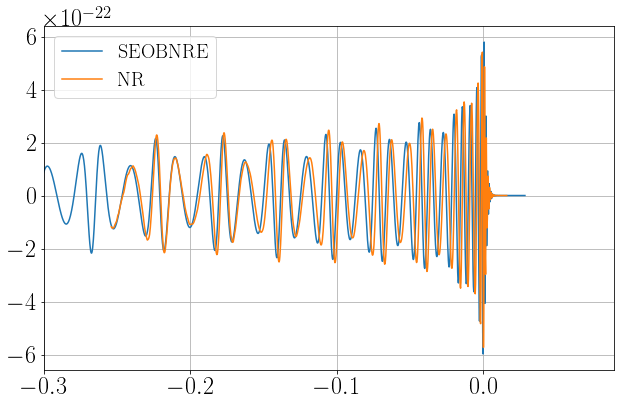

In [65]:
ecc = 0.5777999999999999
nr_hp_phyunit = nr_wf.hp_pycbcts_phyunit(**kwargs)
seobhp,_ = get_td_waveform(approximant='SEOBNRE',**kwargs,eccentricity=ecc)
plt.plot(seobhp.sample_times,seobhp,label='SEOBNRE')
plt.plot(nr_hp_phyunit.sample_times,nr_hp_phyunit,label='NR')
plt.legend()
plt.xlim(-0.3)

In [ ]:

kwargs = {'mass1':10,
          'mass2':10,
          'spin1z':0,
          'spin2z':0,
          'f_lower':20,
          'delta_t':1/4096,
          'distance':400,
          'long_acs_nodes':0,
          'coa_phase':0}